# Data Analysys

### Competition Data

In this competition, Kagglers are challenged to predict the short term price movements during the 10 minute auction period. All the training data is contained within a single train.csv file. Please refer to https://www.kaggle.com/competitions/optiver-trading-at-the-close/data & the introduction in this notebook for specific column definitions.

*   `stock_id` - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
*   `date_id` - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
*   `imbalance_size` - The amount unmatched at the current reference price (in USD).
*   `imbalance_buy_sell_flag` - An indicator reflecting the direction of auction imbalance.
    * buy-side imbalance; 1
    * sell-side imbalance; -1
    * no imbalance; 0
*   `reference_price` - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
*   `matched_size` - The amount that can be matched at the current reference price (in USD).
*   `far_price` - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
*   `near_price` - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
*   `[bid/ask]_price` - Price of the most competitive buy/sell level in the non-auction book.
*   `[bid/ask]_size` - The dollar notional amount on the most competitive buy/sell level  in the non-auction book.
*   `wap` - The weighted average price in the non-auction book. $$\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize} $$
*   `seconds_in_bucket` - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
*   `target` - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index.
    * The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
    * The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a  0.01% price move.
    * Where t is the time at the current observation, we can define the target:
$$ Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) * 10000 $$

**All size related columns are in USD terms.**

**All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.**



In [1]:
from pathlib import Path
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import gc  # Garbage collection for memory management
import os  # Operating system-related functions
import time  # Time-related functions
import warnings  # Handling warnings
from itertools import combinations  # For creating combinations of elements
from warnings import simplefilter  # Simplifying warning handling

# 📦 Importing machine learning libraries
import joblib  # For saving and loading models
import lightgbm as lgb  # LightGBM gradient boosting framework
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
from sklearn.metrics import mean_absolute_error  # Metric for evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit  # Cross-validation techniques

# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

max_lookback = np.nan  # Maximum lookback (not specified)
split_day = 435  # Split day for time series data

warnings.filterwarnings("ignore")

PREV_MAX = 80
# For kaggle environment
if os.environ.get("KAGGLE_DATA_PROXY_TOKEN") != None:
    BASE_OUTPUT_PATH = Path(f'/kaggle/working')
    BASE_INPUT_PATH = Path(f'/kaggle/input/optiver-trading-at-the-close')
    TRAIN_FILE = Path(f'{BASE_INPUT_PATH}/train.csv')
    TEST_FILE = Path(f'{BASE_INPUT_PATH}/test.csv')
    IS_LOCAL = False
    IS_OFFLINE = False
    IS_TRAIN = True
    IS_INFER = True
    DEVICE = "gpu"

# For local environment
else:
    BASE_OUTPUT_PATH = Path(f'../output')
    BASE_INPUT_PATH = Path(f'../kaggle/input/optiver-trading-at-the-close')
    TRAIN_FILE = Path(f'{BASE_INPUT_PATH}/train.csv')
    TEST_FILE = Path(f'{BASE_INPUT_PATH}/test.csv')
    SAMPLE_SUBMISSION_FILE = Path(f'{BASE_INPUT_PATH}/sample_submission.csv')
    REVEALED_TARGETS_FILE = Path(f'{BASE_INPUT_PATH}/revealed_targets.csv')
    IS_LOCAL = True
    IS_OFFLINE = True
    IS_TRAIN = True
    IS_INFER = True
    
    DEVICE = "cpu"

print(f"BASE_OUTPUT_PATH: {BASE_OUTPUT_PATH}")
print(f"BASE_INPUT_PATH: {BASE_INPUT_PATH}")
print(f"TRAIN_FILE: {TRAIN_FILE}")
print(f"TEST_FILE: {TEST_FILE}")

print(f"IS_OFFLINE: {IS_OFFLINE}")
print(f"IS_LOCAL: {IS_LOCAL}")
print(f"IS_TRAIN: {IS_TRAIN}")
print(f"IS_INFER: {IS_INFER}")

BASE_OUTPUT_PATH: ../output
BASE_INPUT_PATH: ../kaggle/input/optiver-trading-at-the-close
TRAIN_FILE: ../kaggle/input/optiver-trading-at-the-close/train.csv
TEST_FILE: ../kaggle/input/optiver-trading-at-the-close/test.csv
IS_OFFLINE: True
IS_LOCAL: True
IS_TRAIN: True
IS_INFER: True


In [2]:
# 🧹 Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    # 🔄 Return the DataFrame with optimized memory usage
    return df

In [3]:
# 🏎️ Import Numba for just-in-time (JIT) compilation and parallel processing
from numba import njit, prange

# 📊 Function to compute triplet imbalance in parallel using Numba
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    # 🔁 Loop through all combinations of triplets
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        # 🔁 Loop through rows of the DataFrame
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            # 🚫 Prevent division by zero
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

# 📈 Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

In [4]:
# 📊 Function to generate imbalance features
def imbalance_features(df):
    if not IS_LOCAL:
        import cudf
        df = cudf.from_pandas(df)
    
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1 features
    # Calculate various features using Pandas eval function
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("ask_price + bid_price")/2
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("imbalance_size-matched_size")/df.eval("matched_size+imbalance_size")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    # Create features for pairwise price imbalances
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
        
    # V2 features
    # Calculate additional features
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    df['match_balance'] = ( df['matched_size']  + (df['imbalance_buy_sell_flag'] * df['imbalance_size'])) / df['matched_size']
    
    # Calculate various statistical aggregation features
    
        
    # V3 features
    # Calculate shifted and return features for specific columns
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    if not IS_LOCAL:
        df = df.to_pandas()
    # Replace infinite values with 0
    return df.replace([np.inf, -np.inf], 0)

def numba_imb_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        
    # Calculate triplet imbalance features using the Numba-optimized function
    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    return df

# 📅 Function to generate time and stock-related features
def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    df["minute"] = df["seconds_in_bucket"] // 60  # Minutes

    # Map global features to the DataFrame
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

# 🚀 Function to generate all features by combining imbalance and other features
def generate_general_features(df):
    # Select relevant columns for feature generation
    base_cols = df.columns

    # Generate imbalance features
    df = imbalance_features(df)
    df = numba_imb_features(df)
    # Generate time and stock-related features
    df = other_features(df)
    gc.collect()  # Perform garbage collection to free up memory


    # added features
    col_added_features= [c for c in df.columns if c not in base_cols]
    
    return df, col_added_features

In [5]:
# Load train dataset
def load_train_dataset():
    df = pd.read_csv(TRAIN_FILE)
    # 🧹 Remove rows with missing values in the "target" column
    df = df.dropna(subset=["target"])
    # 🔁 Reset the index of the DataFrame and apply the changes in place
    df.reset_index(drop=True, inplace=True)
    return df

In [6]:
# Load train dataset
df_train = load_train_dataset()
df_train = df_train[df_train["stock_id"].isin([0,1,100,101])]
colums = df_train.columns
print(colums)

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')


In [7]:
# Step 1. Generate general Global Stock ID Features and basic features
prev_cols = list(df_train.columns)

global_stock_id_feats = {
    "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
    "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
    "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
    "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
    "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
    "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
}
df_global_stock_id_feats = pd.DataFrame(global_stock_id_feats)
df_train, featrues= generate_general_features(df_train)
generated_feature_name = list(set(df_train.columns) - set(prev_cols))
print(generated_feature_name)

['imbalance_size_ret_10', 'ask_price_bid_price_wap_imb2', 'reference_price_wap_imb', 'ask_size_diff_1', 'ask_price_bid_price_imb', 'matched_size_shift_10', 'imbalance_size_ret_2', 'bid_price_wap_reference_price_imb2', 'reference_price_shift_1', 'bid_size_diff_1', 'imbalance_size_shift_2', 'ask_size_diff_3', 'reference_price_ret_3', 'ask_price_bid_price_reference_price_imb2', 'all_sizes_kurt', 'match_balance', 'reference_price_ret_1', 'global_median_price', 'reference_price_ret_2', 'matched_size_shift_3', 'spread_intensity', 'reference_price_ask_price_imb', 'all_prices_std', 'all_sizes_std', 'ask_price_diff_3', 'imbalance_buy_sell_flag_shift_2', 'far_price_wap_imb', 'global_std_price', 'market_urgency', 'volume', 'liquidity_imbalance', 'near_price_bid_price_imb', 'imbalance_size_shift_3', 'imbalance_size_shift_1', 'imbalance_buy_sell_flag_shift_1', 'minute', 'reference_price_near_price_imb', 'global_std_size', 'all_sizes_mean', 'imbalance_buy_sell_flag_ret_2', 'size_imbalance', 'ask_pri

# Step2:  Generate enhanced features

In [8]:
# Step2. Generate enhanced features

## Global features
prev_cols = list(df_train.columns)
def generate_historical_features(df, is_train):
    print("generate_historical_features")

    for col in ['wap', 'match_balance']:
        for window in [1, 2, 3, 10]:
            col_name = f"{col}_diff_{window}"
            df[col_name] = df.groupby("stock_id")[col].diff(window)
            #df[col_name] = df[col_name].fillna(0)  # NaNを0で置き換える
        for period in [5]:
            col_name = f"{col}_vix_{period}"
            df[col_name] = cal_vix(df, ['stock_id', 'date_id'], col, period)

    df = df.replace([np.inf, -np.inf], 0)
    return df


def cal_vix(df, group_key, target_col, period):
    return df.groupby(group_key)[target_col].transform(lambda x: np.log(x).diff().rolling(period).std())

df_train = generate_historical_features(df_train, True)
generated_feature_name = list(set(df_train.columns) - set(prev_cols))
print(generated_feature_name)

KeyError: 'n_wap'

# Step3: Normalized features

In [ ]:
prev_cols = list(df_train.columns)
# 📈 Function to generate normalized features
def generate_normalized_features(df, is_train):
    global global_population_wap
    global global_population_mathch_balance
    global global_population_target
    global global_reference_price

    print("generate_normalized_features")
    if is_train:
        global_population_wap = df['wap'].describe()
        global_population_mathch_balance = df['match_balance'].describe()
        global_population_target = df['target'].describe()
        global_reference_price = df['reference_price'].describe()
        df['n_target'] = (df['target'] - global_population_target['mean']) / global_population_target['std']
    df['n_wap'] = (df['wap'] - global_population_wap['mean']) / global_population_wap['std']
    df['n_match_balance'] = (df['match_balance'] - global_population_mathch_balance['mean']) / global_population_mathch_balance['std']
    df['n_reference_price'] = (df['reference_price'] - global_reference_price['mean']) / global_reference_price['std']
    return df

df_train = generate_normalized_features(df_train, True)
generated_feature_name = list(set(df_train.columns) - set(prev_cols))
print(generated_feature_name)

generate_normalized_features
['n_reference_price', 'n_target', 'n_wap', 'n_match_balance']


# Wap

mean: 1.4321972541037318e-14
std: 0.9999999999999999
min: -9.743284369515408
max: 10.686163417725954


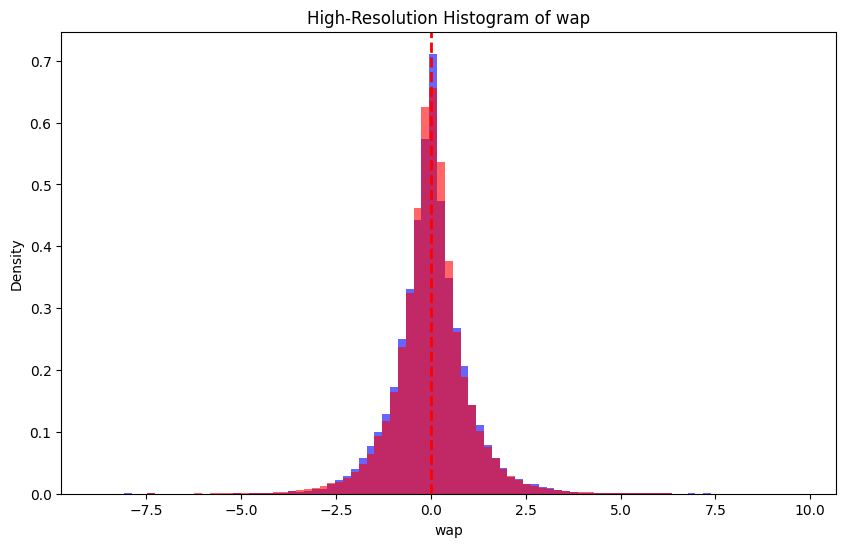

In [ ]:
# Wap Analysys
import matplotlib.pyplot as plt

df = df_train['n_wap']
describe = df.describe()

# 平均と標準偏差の取得
mean = describe['mean']
std = describe['std']
print(f"mean: {mean}")
print(f"std: {std}")
print(f"min: {describe['min']}")
print(f"max: {describe['max']}")

# グラフの解像度を高めるための設定
plt.figure(figsize=(10, 6))  # グラフのサイズを大きくする
bins = np.linspace(describe['min'], describe['max'], 100)  # ビンの数を増やして細かく分割

# ヒストグラムのプロット
plt.hist(df, bins=bins, alpha=0.6, color='blue', density=True)
plt.hist(df_train["n_target"], bins=bins, alpha=0.6, color='red', density=True)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.title('High-Resolution Histogram of wap')
plt.xlabel('wap')
plt.ylabel('Density')

# X軸の範囲を絞る
plt.xlim(describe['min'], describe['max'])

# グラフの表示
plt.show()

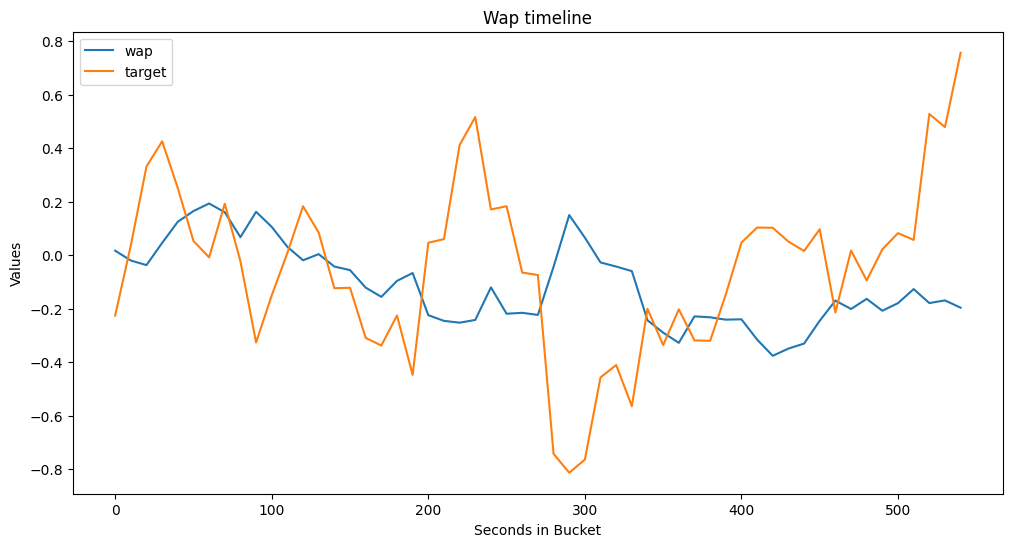

In [ ]:
import matplotlib.pyplot as plt

# 特定の stock_id を選択
stock_id_to_plot = 0

# stock_id に基づいてデータをフィルタリング
df_filtered = df_train[(df_train['stock_id'] == stock_id_to_plot) & (df_train['date_id'] == 0)]

# グラフ描画
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['seconds_in_bucket'], df_filtered['n_wap'], label='wap')
plt.plot(df_filtered['seconds_in_bucket'], df_filtered['n_target'], label='target')

# グラフのタイトルとラベル設定
plt.title(f'Wap timeline')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Values')
plt.legend()

# グラフ表示
plt.show()

# Price

mean: 2.685101126351788e-14
std: 1.0
min: -9.52028047339134
max: 10.606764519552552


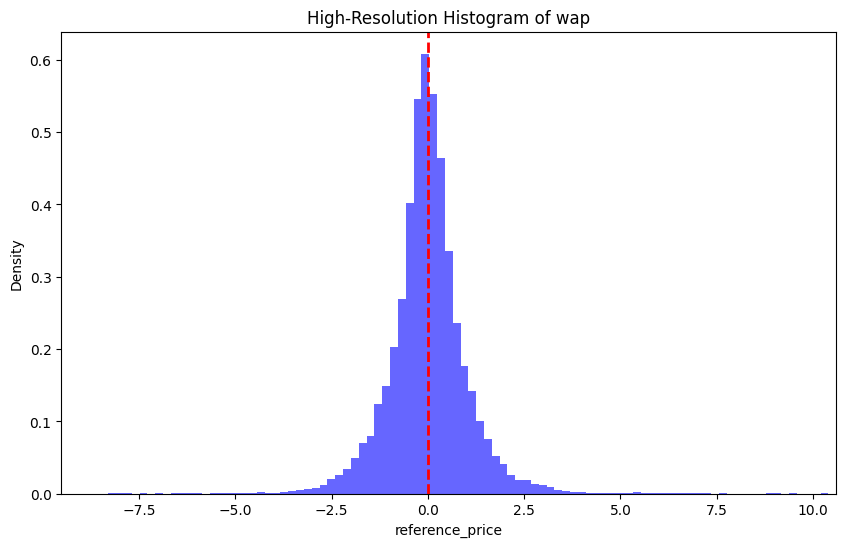

In [ ]:
# Wap Analysys
import matplotlib.pyplot as plt

df = df_train['n_reference_price']
describe = df.describe()

# 平均と標準偏差の取得
mean = describe['mean']
std = describe['std']
print(f"mean: {mean}")
print(f"std: {std}")
print(f"min: {describe['min']}")
print(f"max: {describe['max']}")

# グラフの解像度を高めるための設定
plt.figure(figsize=(10, 6))  # グラフのサイズを大きくする
bins = np.linspace(describe['min'], describe['max'], 100)  # ビンの数を増やして細かく分割

# ヒストグラムのプロット
plt.hist(df, bins=bins, alpha=0.6, color='blue', density=True)
#plt.hist(df_train["n_target"], bins=bins, alpha=0.6, color='red', density=True)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.title('High-Resolution Histogram of wap')
plt.xlabel('reference_price')
plt.ylabel('Density')

# X軸の範囲を絞る
plt.xlim(describe['min'], describe['max'])

# グラフの表示
plt.show()

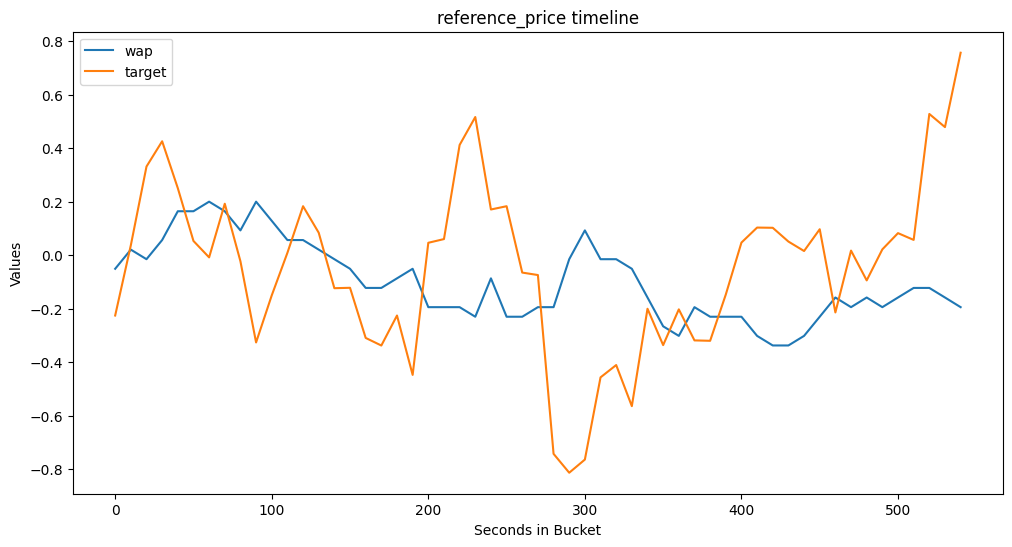

In [ ]:
import matplotlib.pyplot as plt

# 特定の stock_id を選択
stock_id_to_plot = 0

# stock_id に基づいてデータをフィルタリング
df_filtered = df_train[(df_train['stock_id'] == stock_id_to_plot) & (df_train['date_id'] == 0)]

# グラフ描画
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['seconds_in_bucket'], df_filtered['n_reference_price'], label='wap')
plt.plot(df_filtered['seconds_in_bucket'], df_filtered['n_target'], label='target')

# グラフのタイトルとラベル設定
plt.title(f'reference_price timeline')
plt.xlabel('Seconds in Bucket')
plt.ylabel('Values')
plt.legend()

# グラフ表示
plt.show()

# Predict